In [1]:
import gpytorch
import numpy as np
import pandas as pd
import torch

from bo_functions import ExactGPModel
from bo_functions import create_y_data
from bo_functions_GP_Analysis import test_train_split
from bo_functions_GP_Analysis import bo_iter_w_runs
from datetime import datetime

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 200

/afs/crc.nd.edu/user/m/mcarlozo/.conda/envs/Toy_Problem_env/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#Set Date and Time
dateTimeObj = datetime.now()
timestampStr = dateTimeObj.strftime("%d-%b-%Y (%H:%M:%S)")
print("Date and Time: ", timestampStr)
# DateTime = dateTimeObj.strftime("%Y/%m/%d/%H-%M-%S%p")
DateTime = None ##For Testing

#Set Parameters
Theta_True = np.array([1,-1])
BO_iters = 2
train_iter = 300
noise_std = 0.1
runs = 1
explore_bias = torch.tensor([0.75])
shuffle_seed = 6
set_lengthscale = None
# t= 20
emulator = True
sparse_grid = True
verbose = True
save_fig=False

#Pull Experimental data from CSV
exp_data_doc = 'Input_CSVs/Exp_Data/n=5.csv'
exp_data = np.array(pd.read_csv(exp_data_doc, header=0,sep=","))
Xexp = exp_data[:,1]
Yexp = exp_data[:,2]
n = len(Xexp)

#Define GP Testing space
p=20
Theta1 =  np.linspace(-2,2,p) #1x10
Theta2 =  np.linspace(-2,2,p) #1x10
theta_mesh = np.array(np.meshgrid(Theta1, Theta2)) #2 Uniform 5x5 arrays

Date and Time:  22-Jul-2022 (15:58:32)


Runs: 1
BO Iters: 2
------------------------------
Lengthscale Set To: None
Explore Bias: 0.75
Run Number:  1
Test point is: [1.85665735 0.76582816 1.24174844]


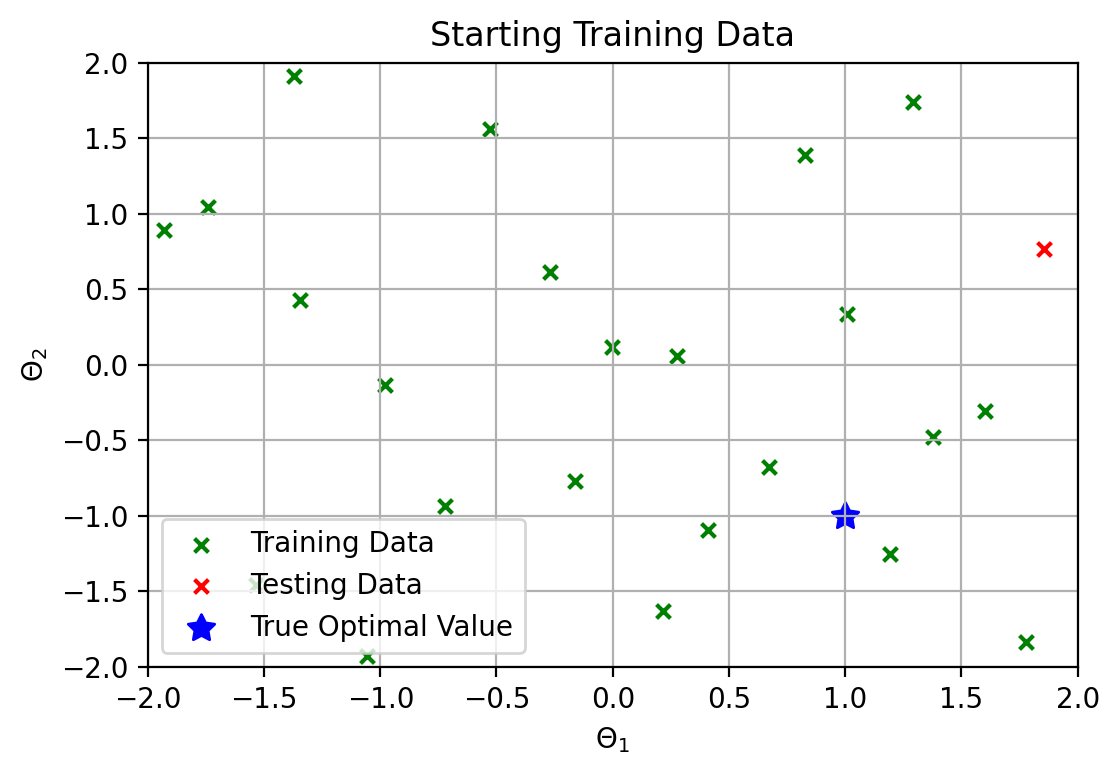

BO Iteration =  1


NameError: name 'mean_of_var' is not defined

In [3]:
%%time
obj = "obj"

all_data_doc = "Input_CSVs/Train_Data/all_3_data/t=25.csv"
all_data = np.array(pd.read_csv(all_data_doc, header=0,sep=",")) 

t = len(all_data)

print("Runs:", runs)
print("BO Iters:",BO_iters)
print("------------------------------")

print("Lengthscale Set To:", set_lengthscale)
print("Explore Bias:", str(np.round(float(explore_bias[0]),3)))
results = bo_iter_w_runs(BO_iters,all_data_doc,t,theta_mesh,Theta_True,train_iter,explore_bias[0], Xexp, Yexp,
                                 noise_std, obj, runs, sparse_grid, emulator, set_lengthscale, verbose, 
                                 save_fig, shuffle_seed, DateTime)